### Importações

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
pd.set_option('display.float_format', '{:,.2f}'.format)

### Carregar dados

In [4]:
df = pd.read_parquet('./Base/base_pronta_2023 2025.03.03.parquet')
df.drop(columns=['pib_nominal', 'alunos_escola', 'quantidade_total_vagas', 'RCL'], inplace=True)

In [5]:
encoder_sub = LabelEncoder()
df['cod_subelemento_transformed'] = encoder_sub.fit_transform(df['cod_subelemento'])

In [6]:
df.columns

Index(['ano_exercicio', 'cd_municipio_ibge', 'ds_municipio', 'cod_subelemento',
       'vl_despesa', 'pop_total', 'atividade_principal', 'vereadores', 'area',
       'Agropecuária', 'Indústria', 'Administração Pública',
       'Total  (exclusive Administração Pública)', 'Total geral', 'Impostos',
       'PIB (1)', 'PIB per Capita (2)', 'Efetivo', 'Efetivo em Comissão',
       'Exclusivamente em Comissão', 'QT_MAT_BAS', 'QT_MAT_INF', 'QT_MAT_FUND',
       'QT_DOC_BAS', 'QT_DOC_INF', 'QT_DOC_FUND', 'receitas_correntes',
       'receitas_capital', 'receita_total', 'leitos_total', 'leitos_hab',
       'leitos sus', 'leitos_sus_hab', 'leitos não sus', 'leitos_naosus_hab',
       'cod_subelemento_transformed'],
      dtype='object')

In [7]:
cols = [
       'cd_municipio_ibge', 'cod_subelemento', 'cod_subelemento_transformed',
       'pop_total', 'vereadores', 'area',
       'Agropecuária', 'Indústria', 'Administração Pública', 'Total  (exclusive Administração Pública)', 'Impostos', 'PIB per Capita (2)', 
       'QT_MAT_INF', 'QT_MAT_FUND', 'QT_DOC_INF', 'QT_DOC_FUND', 
       'receitas_correntes', 'receitas_capital', 
       'leitos sus', 'leitos_sus_hab',
       'vl_despesa', 
        ]

### Treinando o modelo após exclusão das variáveis altamente correlacionadas

In [8]:
# Separar os dados de treino (2010-2022) e teste (2023)
df_train = df.loc[(df['ano_exercicio'] <= 2022), cols].drop(columns=['cd_municipio_ibge', 'cod_subelemento']).copy()
df_test = df.loc[df['ano_exercicio'] == 2023, cols].copy()

In [9]:
# Definir variáveis preditoras e alvo
X_train = df_train.drop(columns='vl_despesa')
y_train = df_train['vl_despesa']

X_test = df_test  # Vamos prever `vl_despesa` para esse conjunto

In [11]:
# Lista de colunas numéricas
cols_num = ['pop_total', 'vereadores', 'area',
            'Agropecuária', 'Indústria', 'Administração Pública', 'Total  (exclusive Administração Pública)', 'Impostos', 'PIB per Capita (2)', 
            'QT_MAT_INF', 'QT_MAT_FUND', 'QT_DOC_INF', 'QT_DOC_FUND', 
            'receitas_correntes', 'receitas_capital', 
            'leitos sus', 'leitos_sus_hab']

# Inicializar o StandardScaler
scaler = StandardScaler()

# Criar cópias dos datasets para evitar modificar os originais
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Aplicar a normalização apenas nas colunas numéricas
X_train_scaled[cols_num] = scaler.fit_transform(X_train[cols_num])
X_test_scaled[cols_num] = scaler.transform(X_test[cols_num])

In [12]:
# Modelos
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_lgbm = LGBMRegressor(n_estimators=100, random_state=42)

In [13]:
model_rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [14]:
model_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4077
[LightGBM] [Info] Number of data points in the train set: 435949, number of used features: 18
[LightGBM] [Info] Start training from score 3721033.424980


LGBMRegressor(random_state=42)

In [15]:
# Previsão para 2023
df_test['vl_despesa_pred_rf'] = model_rf.predict(X_test_scaled.drop(columns=['cd_municipio_ibge', 'cod_subelemento', 'vl_despesa']))
df_test['vl_despesa_pred_lgbm'] = model_lgbm.predict(X_test_scaled.drop(columns=['cd_municipio_ibge', 'cod_subelemento', 'vl_despesa']))

from datetime import datetime

# Obter a data atual no formato AAAA.MM.DD
hoje = datetime.today().strftime('%Y.%m.%d')

# Exportar resultados
df_test[['cd_municipio_ibge', 'cod_subelemento', 'vl_despesa', 
         'vl_despesa_pred_rf', 'vl_despesa_pred_lgbm']].to_csv(f'previsao_2023 variáveis principais {hoje} v2.csv', index=False)

print("Previsões para 2023 salvas em 'previsao_2023.csv'.")

Previsões para 2023 salvas em 'previsao_2023.csv'.


In [16]:
df_test[['cd_municipio_ibge', 'cod_subelemento', 'vl_despesa', 
         'vl_despesa_pred_rf', 'vl_despesa_pred_lgbm']]

,cd_municipio_ibge,cod_subelemento,vl_despesa,vl_despesa_pred_rf,vl_despesa_pred_lgbm
435949,3500105,0100,"2,980,216.47","2,634,727.09","887,674.48"
435950,3500105,0300,"2,637,136.72","1,949,716.56","887,674.48"
435951,3500105,0400,"754,057.27","1,419,484.34","1,494,876.28"
435952,3500105,1101,"33,049,723.06","33,907,549.53","38,270,934.14"
435953,3500105,1110,"2,761,197.23","2,063,126.52","1,939,513.86"
...,...,...,...,...,...
474427,3533809,5199,"424,122.54","1,037,706.94","917,683.69"
474428,3533809,5200,"957,348.57","1,226,282.63","537,152.27"
474429,3533809,9100,"223,698.24","184,430.42","429,939.94"
474430,3533809,9300,"69,756.07","209,139.61","-40,021.54"


### Avaliação dos Modelos

In [18]:
# Separação treino/validação dentro dos dados de 2010-2022
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Treinamento novamente nos dados reduzidos
model_rf.fit(X_train_split, y_train_split)
model_lgbm.fit(X_train_split, y_train_split)

# Previsões na validação
y_pred_rf = model_rf.predict(X_val)
y_pred_lgbm = model_lgbm.predict(X_val)

# Função de avaliação
def avaliar_modelo(y_true, y_pred, nome_modelo):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{nome_modelo} - MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4077
[LightGBM] [Info] Number of data points in the train set: 348759, number of used features: 18
[LightGBM] [Info] Start training from score 3731643.446356


In [19]:
# Avaliação dos três modelos
avaliar_modelo(y_val, y_pred_rf, 'Random Forest')
avaliar_modelo(y_val, y_pred_lgbm, 'LightGBM')

Random Forest - MAE: 1438101.48, MSE: 88180378131292.44, R²: 0.85
LightGBM - MAE: 2247330.18, MSE: 115550037482325.61, R²: 0.81


In [ ]:
# Avaliação dos modelos com dados reais
avaliar_modelo(df_test['vl_despesa'], df_test['vl_despesa_pred_rf'], 'Random Forest')
avaliar_modelo(df_test['vl_despesa'],df_test['vl_despesa_pred_lgbm'], 'LightGBM')

Random Forest - MAE: 1875888.64, MSE: 98387727085780.28, R²: 0.86
LightGBM - MAE: 2868724.25, MSE: 158660025303099.03, R²: 0.77


In [ ]:
# Definir os parâmetros para busca do Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

# Definir os parâmetros para busca do LightGBM
param_grid_lgbm = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, -1]  # -1 significa sem limite de profundidade
}

# Criar os modelos base
rf = RandomForestRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)

# Aplicar GridSearchCV no Random Forest
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_scaled, y_train)

# Aplicar GridSearchCV no LightGBM
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_lgbm.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5161
[LightGBM] [Info] Number of data points in the train set: 435949, number of used features: 23
[LightGBM] [Info] Start training from score 3721033.424980


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [10, 20, -1],
                         'n_estimators': [100, 300, 500],
                         'num_leaves': [31, 50, 100]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
# Exibir os melhores hiperparâmetros
print("Melhores parâmetros para Random Forest:", grid_rf.best_params_)
print("Melhores parâmetros para LightGBM:", grid_lgbm.best_params_)

Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhores parâmetros para LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 100}


In [ ]:
# Salvar os melhores hiperparâmetros em um arquivo JSON
best_params = {
    "RandomForest": grid_rf.best_params_,
    "LightGBM": grid_lgbm.best_params_
}

with open("best_params.json", "w") as f:
    json.dump(best_params, f)

print("Hiperparâmetros salvos em best_params.json")

Hiperparâmetros salvos em best_params.json


In [ ]:
# Carregar os hiperparâmetros salvos
with open("best_params.json", "r") as f:
    best_params = json.load(f)


# Exibir os melhores hiperparâmetros
print("Melhores parâmetros para Random Forest:", grid_rf.best_params_)
print("Melhores parâmetros para LightGBM:", grid_lgbm.best_params_)

Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhores parâmetros para LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 100}


In [ ]:
# Treinar Random Forest com os melhores parâmetros
best_rf = RandomForestRegressor(**grid_rf.best_params_, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Treinar LightGBM com os melhores parâmetros
best_lgbm = LGBMRegressor(**grid_lgbm.best_params_, random_state=42)
best_lgbm.fit(X_train_scaled, y_train)

# Salvar os modelos treinados
joblib.dump(best_rf, "random_forest_model.pkl")
joblib.dump(best_lgbm, "lightgbm_model.pkl")

print("Modelos treinados e salvos com sucesso!")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5161
[LightGBM] [Info] Number of data points in the train set: 435949, number of used features: 23
[LightGBM] [Info] Start training from score 3721033.424980
Modelos treinados e salvos com sucesso!


##### Carregar os modelos salvos
rf_loaded = joblib.load("random_forest_model.pkl")
lgbm_loaded = joblib.load("lightgbm_model.pkl")

##### Fazer previsões com os modelos carregados
y_pred_rf = rf_loaded.predict(X_test_scaled)
y_pred_lgbm = lgbm_loaded.predict(X_test_scaled)

In [ ]:
# Fazer previsões e avaliar novamente
y_pred_rf_best = best_rf.predict(X_val)
y_pred_lgbm_best = best_lgbm.predict(X_val)

avaliar_modelo(y_val, y_pred_rf_best, 'Random Forest Otimizado')
avaliar_modelo(y_val, y_pred_lgbm_best, 'LightGBM Otimizado')

Random Forest Otimizado - MAE: 495951.96, MSE: 10957493987486.69, R²: 0.98
LightGBM Otimizado - MAE: 1280812.20, MSE: 20765189195328.67, R²: 0.97


In [ ]:
# Previsão para 2023
df_test['vl_despesa_pred_rf_otimizado'] = best_rf.predict(X_test_scaled.drop(columns=['cd_municipio_ibge', 'cod_subelemento', 'vl_despesa']))
df_test['vl_despesa_pred_lgbm_otimizado'] = best_lgbm.predict(X_test_scaled.drop(columns=['cd_municipio_ibge', 'cod_subelemento', 'vl_despesa']))

In [ ]:
# Avaliação dos modelos com dados reais
avaliar_modelo(df_test['vl_despesa'], df_test['vl_despesa_pred_rf_otimizado'], 'Random Forest')
avaliar_modelo(df_test['vl_despesa'],df_test['vl_despesa_pred_lgbm_otimizado'], 'LightGBM')

Random Forest - MAE: 1881018.91, MSE: 97442005228836.89, R²: 0.86
LightGBM - MAE: 2241372.42, MSE: 90696785048187.67, R²: 0.87


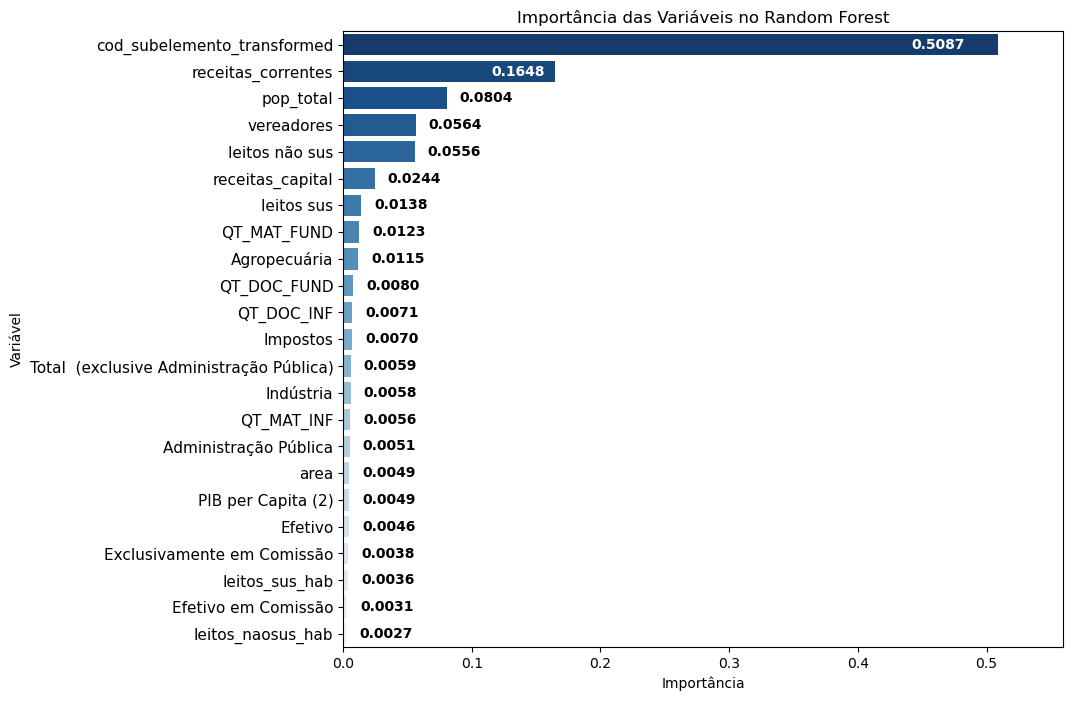

In [ ]:
# Obter a importância das variáveis no modelo treinado
importances = best_rf.feature_importances_

# Criar um DataFrame com os nomes das variáveis e suas importâncias
feature_importance_df = pd.DataFrame({'Variável': X_train.columns, 'Importância': importances})

# Ordenar da mais importante para a menos importante
feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False)

# Criar o gráfico
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importância', y='Variável', data=feature_importance_df, palette='Blues_r', hue='Variável', legend=False)

# Definir o limite do eixo X para dar espaço aos valores
max_value = feature_importance_df['Importância'].max()
plt.xlim(0, max_value * 1.1)  # Adicionar 10% de margem para evitar corte

# Adicionar os valores nas barras com lógica adaptada
for i, (valor, var) in enumerate(zip(feature_importance_df['Importância'], feature_importance_df['Variável'])):
    if valor > max_value * 0.3:  # Se a barra for grande, colocar o texto dentro (branco)
        ax.text(valor * 0.95, i, f'{valor:.4f}', 
                va='center', ha='right', fontsize=10, fontweight='bold', color='white')
    else:  # Se a barra for pequena, manter o texto fora (preto)
        ax.text(valor + (max_value * 0.02), i, f'{valor:.4f}', 
                va='center', fontsize=10, fontweight='bold', color='black')

# Ajustar espaçamento entre os rótulos do eixo Y
plt.xticks(rotation=0)
plt.yticks(fontsize=11)  # Fonte maior para os rótulos do eixo Y
plt.subplots_adjust(left=0.3)  # Mais espaço no lado esquerdo para os rótulos

# Definir rótulos e título
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis no Random Forest')

# Exibir o gráfico
plt.show()

In [ ]:
feature_importance_df

,Variável,Importância
0,cod_subelemento_transformed,0.51
17,receitas_correntes,0.16
1,pop_total,0.08
2,vereadores,0.06
21,leitos não sus,0.06
18,receitas_capital,0.02
19,leitos sus,0.01
14,QT_MAT_FUND,0.01
4,Agropecuária,0.01
16,QT_DOC_FUND,0.01
